# Exploring pipeline data

#### Imports

In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import pyopia.exampledata

import os
import matplotlib.pyplot as plt

#### Setup and run a pipeline as normal

In [2]:
model_path = pyopia.exampledata.get_example_model(os.getcwd())

# Prepare folders
os.makedirs('proc', exist_ok=True)

# remove pre-existing output file (as statistics for each image are appended to it)
datafile_nc = os.path.join('proc', 'test')
if os.path.isfile(datafile_nc + '-STATS.nc'):
  os.remove(datafile_nc + '-STATS.nc')
  
toml_settings = pyopia.io.load_toml('config.toml')

# Initialise the pipeline and run the initial steps
MyPipeline = pyopia.pipeline.Pipeline(toml_settings)

# Load an image (from the test suite)
filename = pyopia.exampledata.get_example_silc_image(os.getcwd())

# Process the image to obtain the stats dataframe
stats = MyPipeline.run(filename)

Initialising pipeline
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'raw_files'])
Example image already exists. Skipping download.
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename'])
ImagePrep  ready with: {'image_level': 'imraw'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw'])
Segment  ready with: {'threshold': 0.85}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'imc', 'imref'])
segment
clean
CalculateStats  ready with: {}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'imc', 'imref', 'imbw'])
statextract
21.7% saturation
measure
  870 particles found
EXTRACTING 870 IMAGES from 870
StatsToDisc  ready with: {'output_datafile': './test'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'imc', 'imref', 'imbw', 'stats'])


#### Pipeline data available

Now the pipeline has finished, we can look at the keys in Pipeline.data to see what is available.

Full documentation is here: {class}`pyopia.pipeline.Data`

In [3]:
print(MyPipeline.data.keys())

dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'imc', 'imref', 'imbw', 'stats'])


#### Visualise the reference, 2-D corrected image, and segmented image

This helps us see the quality of the image that is passed to the pipeline, and how well the segmentation performed in separating particles from the background.

In [4]:
MyPipeline.data['imraw']

array([[[0.30196078, 0.2745098 , 0.25098039],
        [0.29803922, 0.2627451 , 0.25098039],
        [0.29411765, 0.25098039, 0.20784314],
        ...,
        [0.40392157, 0.35686275, 0.3254902 ],
        [0.38039216, 0.35686275, 0.30980392],
        [0.38039216, 0.37647059, 0.29411765]],

       [[0.32156863, 0.28627451, 0.25098039],
        [0.31372549, 0.27843137, 0.25098039],
        [0.30588235, 0.26666667, 0.20784314],
        ...,
        [0.38431373, 0.36078431, 0.3254902 ],
        [0.37647059, 0.34901961, 0.30980392],
        [0.37647059, 0.35686275, 0.29411765]],

       [[0.3372549 , 0.30196078, 0.26666667],
        [0.32941176, 0.29411765, 0.26666667],
        [0.32156863, 0.28627451, 0.22745098],
        ...,
        [0.36470588, 0.35686275, 0.31372549],
        [0.37254902, 0.35294118, 0.31372549],
        [0.37254902, 0.35686275, 0.31764706]],

       ...,

       [[0.38823529, 0.37647059, 0.3372549 ],
        [0.4       , 0.36470588, 0.3372549 ],
        [0.40784314, 0

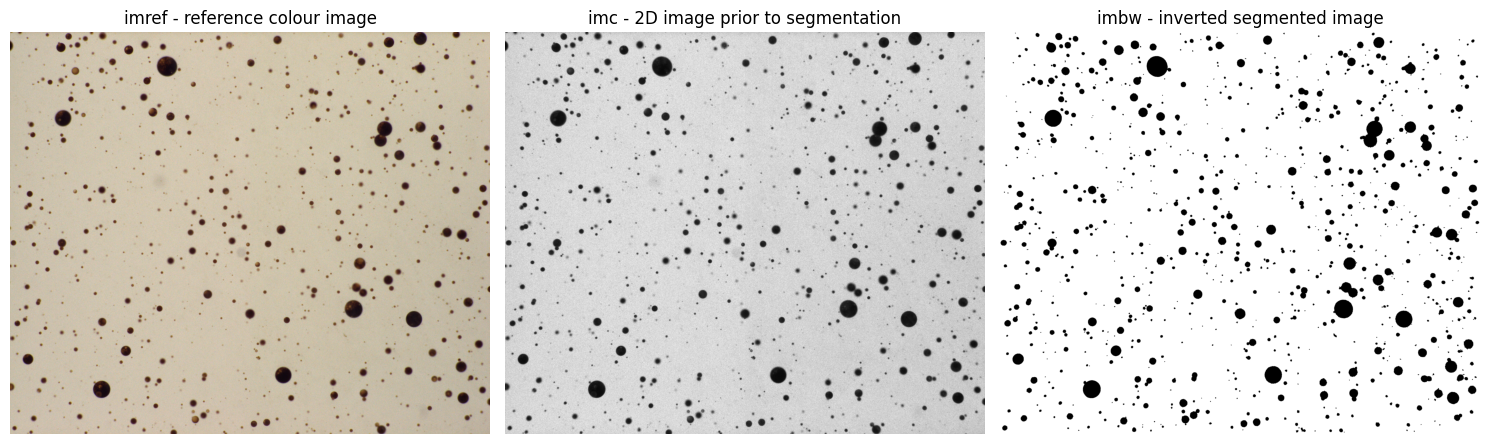

In [5]:
f, a = plt.subplots(1,3, figsize=(15,10))

a[0].imshow(MyPipeline.data['imref'], cmap='grey')
a[0].set_title('imref - reference colour image')
a[0].axis('off')
a[1].imshow(MyPipeline.data['imc'], cmap='grey')
a[1].set_title('imc - 2D image prior to segmentation')
a[1].axis('off')
a[2].imshow(~MyPipeline.data['imbw'], cmap='grey')
a[2].set_title('imbw - inverted segmented image')
a[2].axis('off')
plt.tight_layout()

#### Check classified size distribution statistics

Now we can quickly plot the some size distributions and check what the classifier returned

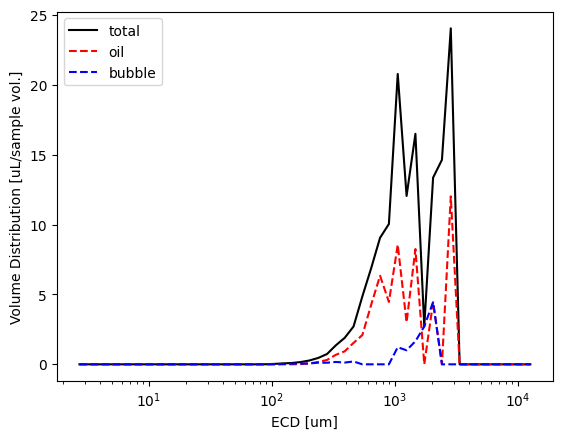

In [6]:
MyPipeline.data['xstats'] = pyopia.io.make_xstats(MyPipeline.data['stats'], toml_settings)
xstats = MyPipeline.data['xstats']
dias, vd_total = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

stats = MyPipeline.data['stats']
oil = stats[stats['probability_oil'] > 0.5] # a very cruide extraction of particles with moderate probability of being oil
bubble = stats[stats['probability_bubble'] > 0.5] # a very cruide extraction of particles with moderate probability of being bubbles

dias, vd_oil = pyopia.statistics.vd_from_stats(oil, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])
dias, vd_bubble = pyopia.statistics.vd_from_stats(bubble, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])


plt.plot(dias, vd_total, 'k', label=f"total")
plt.plot(dias, vd_oil, '--', color='r', label="oil")
plt.plot(dias, vd_bubble, '--', color='b', label="bubble")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')
plt.legend();

#### Crude classification histogram

We take take a look at a summary of the number frequency distribution of the highest probability class from the classifier like this.

Note: Often for oil and bubbles, we work with volume distributions - the below histogram is number-based so will be biassed towards the very smallest particles for typical droplet size distributions.

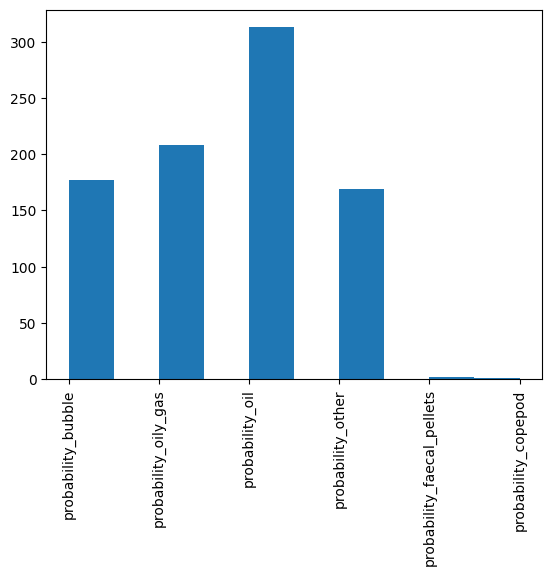

In [7]:
stats = pyopia.statistics.add_best_guesses_to_stats(stats)

plt.hist(stats['best guess'])
plt.xticks(rotation=90);